In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import time
import re
import nltk
import math
import os
import matplotlib.pyplot as plt
import sklearn.metrics

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model
from sklearn.linear_model import Perceptron

from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import PassiveAggressiveClassifier

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import pickle

%matplotlib inline


## Load csv files

In [2]:
proteins = pd.read_csv('protein-SevenLocations-Feb12.csv')

proteins.head()

,name,sequence,location,label
0,tr|A0A0N4VT99|A0A0N4VT99_HAEPC,LLFVWLPQFIVRPHALLRFWMETDCQGNPPMYGDFEAQRHWMEITI...,0,ER
1,tr|A0A3P8RTP6|A0A3P8RTP6_AMPPE,MGRCVFLILAVLFSVTSSQFIPPYTEDCRTEMYPPKGPTYRGAVGW...,3,lysosome
2,sp|O89290|POL_HV193,MGARASVLSGGKLDAWEKIRLRPGGKKKYRLKHLVWASRELERFAL...,6,plasma_membrane
3,tr|S2JAV3|S2JAV3_MUCC1,MVKKQKKKQPITARVQPTEAKFKHSRVETARLIRKFHVLNKELAKC...,5,nucleus
4,sp|A5I7A5|UVRC_CLOBH,MFDLEYQLKNLPDKPGVYLMKNNLGEIIYVGKAKILKNRVRQYFQK...,2,cytoplasm


In [3]:
proteins.shape

(700483, 4)

In [4]:
# permute/scramble/shuffle rows of the dataframe
proteins = proteins.sample(frac=1)

In [5]:
proteins.location.value_counts()

5    178929
0    118331
4    109750
2     97116
1     75188
3     60911
6     60258
Name: location, dtype: int64

In [6]:
proteins.label.value_counts()

nucleus            178929
ER                 118331
mitochondria       109750
cytoplasm           97116
Golgi               75188
lysosome            60911
plasma_membrane     60258
Name: label, dtype: int64

In [7]:
# remove the duplicate protein sequences
proteins = proteins.drop_duplicates(subset='sequence', keep="first")

# remove nan from 'sequence' column
proteins = proteins[proteins['sequence'].notnull()]

proteins.shape

(700483, 4)

In [8]:
proteins.label.value_counts()

nucleus            178929
ER                 118331
mitochondria       109750
cytoplasm           97116
Golgi               75188
lysosome            60911
plasma_membrane     60258
Name: label, dtype: int64

## Transform the protein sequence data with CountVectorizer to get peptide frequency. Split the data into training & test sets.

In [9]:
# Peptide count is used for analysis
peptide_size = 6
vect = CountVectorizer(min_df=1,token_pattern=r'\w{1}',ngram_range=(peptide_size,peptide_size))

In [10]:
X = vect.fit_transform(proteins.sequence)
y = proteins.location

In [11]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state =42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

((560386, 34701392), (560386,))
((140097, 34701392), (140097,))


In [12]:
y_test.value_counts()

5    35677
0    23654
4    22178
2    19492
1    14891
3    12251
6    11954
Name: location, dtype: int64

## Classifiers

In [13]:
%%time
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
# evaluate accuracy of our model on test data
print("MNB classifier Score: {:.2f}".format(mnb.score(X_test, y_test)))
print()

MNB classifier Score: 0.92
()
CPU times: user 35.6 s, sys: 18.8 s, total: 54.4 s
Wall time: 1min 6s


In [14]:
%%time
pac = PassiveAggressiveClassifier()
pac.fit(X_train, y_train)
# evaluate accuracy of our model on test data
print("Passive Aggressive classifier Score: {:.2f}".format(pac.score(X_test, y_test)))
print()

/Users/scottlew/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Passive Aggressive classifier Score: 0.94
()
CPU times: user 3min 16s, sys: 12.8 s, total: 3min 28s
Wall time: 3min 42s


In [15]:
%%time
pac2 = PassiveAggressiveClassifier(loss='squared_hinge')
pac2.fit(X_train, y_train)
# evaluate accuracy of our model on test data
print("Passive Aggressive classifier with squared hinge loss Score: {:.2f}".format(pac2.score(X_test, y_test)))
print()

Passive Aggressive classifier with squared hinge loss Score: 0.94
()
CPU times: user 3min 1s, sys: 10.3 s, total: 3min 11s
Wall time: 3min 20s


In [16]:
# Generate Confusion Matrix 
actual = y_test
predictions = pac2.predict(X_test)
print('Confusion Matrix for Majority Vote Model')
print()
cm = confusion_matrix(actual,predictions)
print(cm)

Confusion Matrix for Majority Vote Model
()
[[22448   371    53    19    87   179   497]
 [  325 14256    43    21    23    48   175]
 [   34    10 17738    26   166   972   546]
 [   21    21    57 11779    10    94   269]
 [  120    16   397    20 20488   420   717]
 [   61     2   770    37   197 33747   863]
 [   54    11   427    93   108   448 10813]]


In [17]:
%%time
sgd = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
sgd.fit(X_train, y_train)
# evaluate accuracy of our model on test data
print("SGD classifier Score: {:.2f}".format(sgd.score(X_test, y_test)))
print()

SGD classifier Score: 0.94
()
CPU times: user 7min 20s, sys: 10.8 s, total: 7min 31s
Wall time: 44min 54s


In [18]:
%%time
per = Perceptron(tol=1e-3, random_state=0).fit(X_train,y_train)
# evaluate accuracy of our model on test data
print("Perceptron classifier Score: {:.2f}".format(per.score(X_test, y_test)))
print()

Perceptron classifier Score: 0.93
()
CPU times: user 22min 17s, sys: 24 s, total: 22min 41s
Wall time: 38min 51s


## Majority Vote Classifiers

In [19]:
# three classifiers: SGD, PassiveAggressiveClassifier, MNB

clf1 = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
clf2 = PassiveAggressiveClassifier()
clf3 = MultinomialNB()

In [20]:
eclf1 = VotingClassifier(estimators=[('sgd', clf1), ('pac', clf2), ('mnb', clf3)], voting='hard')
eclf1 = eclf1.fit(X_train, y_train)
# evaluate accuracy of our model on test data
print("Majority Voting Classifier Score: {:.2f}".format(eclf1.score(X_test, y_test)))

Majority Voting Classifier Score: 0.94


In [21]:
# Generate Confusion Matrix 
actual = y_test
predictions = eclf1.predict(X_test)
print('Confusion Matrix for Majority Vote Model')
print()
cm = confusion_matrix(actual,predictions)
print(cm)

Confusion Matrix for Majority Vote Model
()
[[22649   362    74    20    78   213   258]
 [  323 14348    40    22    17    98    43]
 [   37    10 17840    25   155  1140   285]
 [   27    29   100 11802     5   146   142]
 [  132    15   480    22 20604   645   280]
 [   68     2   792    39   193 34228   355]
 [   64    11   526    99   112   610 10532]]


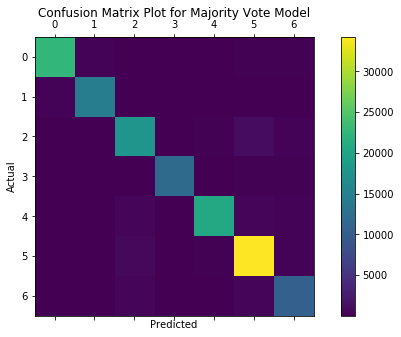

In [22]:
# Nice plot of confusion matrix
# Adjust size of confusion matrix by following code taken from StackOverflow
# https://stackoverflow.com/questions/43021762/matplotlib-how-to-change-figsize-for-matshow
plt.figure(figsize=(10,5))
plt.matshow(cm, fignum=1)

plt.title('Confusion Matrix Plot for Majority Vote Model')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

In [23]:
vote_prediction1 = eclf1.predict(X_test)
print(classification_report(vote_prediction1, y_test))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     23300
           1       0.96      0.97      0.97     14777
           2       0.92      0.90      0.91     19852
           3       0.96      0.98      0.97     12029
           4       0.93      0.97      0.95     21164
           5       0.96      0.92      0.94     37080
           6       0.88      0.89      0.88     11895

   micro avg       0.94      0.94      0.94    140097
   macro avg       0.94      0.94      0.94    140097
weighted avg       0.94      0.94      0.94    140097



In [27]:
vote_prediction2 = eclf2.predict(X_test)
print(classification_report(vote_prediction2, y_test))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     23409
           1       0.96      0.97      0.97     14757
           2       0.92      0.90      0.91     19940
           3       0.97      0.98      0.97     12082
           4       0.93      0.97      0.95     21185
           5       0.96      0.92      0.94     36992
           6       0.87      0.89      0.88     11732

   micro avg       0.94      0.94      0.94    140097
   macro avg       0.94      0.94      0.94    140097
weighted avg       0.94      0.94      0.94    140097

